# Регрессия SVM

## Импорт модулей

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
)
import joblib

## Константы

In [2]:
TRAIN_PATH = "../Lesson36/train.csv"
TARGET = "Premium Amount"
RANDOM_STATE = 777
TEST_SIZE = 0.2

## Загрузка данных

In [3]:
df = pd.read_csv(TRAIN_PATH, index_col="id")

print("Train DataFrame")
df.head()

Train DataFrame


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

## Исследовательский анализ данных

In [5]:
# Удалим колонку с датой
df = df.drop(columns=["Policy Start Date"])

# Выделим числовые и категориальные признаки
numeric_columns = [
    col for col in df.columns if df[col].dtype == "float64" if col != TARGET
]
categoric_columns = [col for col in df.columns if df[col].dtype == "object"]

Проверка дубликатов.

In [6]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 1


Удаление дубликатов.

In [7]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


In [8]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats


def categoric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Количество уникальных значений"] = df.nunique()
    stats["Мода"] = df.mode().transpose()

    return stats

In [9]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns + [TARGET]])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
Age,1.558751e-02,18.00,64.00,41.15,41.00,1.833300e+02,22.00,60.00,30.00,53.00
Annual Income,3.745753e-02,1.00,149997.00,32745.21,23911.00,1.035521e+09,2626.90,81075.00,8001.00,44634.00
Number of Dependents,9.139341e-02,0.00,4.00,2.01,2.00,2.010000e+00,0.00,4.00,1.00,3.00
Health Score,6.173005e-02,2.01,58.98,25.61,24.58,1.489200e+02,9.94,43.28,15.92,34.53
Previous Claims,3.033578e-01,0.00,9.00,1.00,1.00,9.700000e-01,0.00,2.00,0.00,2.00
Vehicle Age,5.000004e-06,0.00,19.00,9.57,10.00,3.336000e+01,2.00,18.00,5.00,15.00
Credit Score,1.149018e-01,300.00,849.00,592.92,595.00,2.249458e+04,383.00,792.00,468.00,721.00
Insurance Duration,8.333340e-07,1.00,9.00,5.02,5.00,6.730000e+00,1.00,9.00,3.00,7.00
Premium Amount,0.000000e+00,20.00,4999.00,1102.55,872.00,7.482235e+05,150.00,2363.00,514.00,1509.00


In [10]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.000000,2,Male
Marital Status,0.015441,3,Single
Education Level,0.000000,4,Master's
Occupation,0.298396,3,Employed
Location,0.000000,3,Suburban
Policy Type,0.000000,3,Premium
Customer Feedback,0.064853,3,Average
Smoking Status,0.000000,2,Yes
Exercise Frequency,0.000000,4,Weekly
Property Type,0.000000,3,House


Данные содержат пропущенные значения и имеют различный масштаб.

## Подготовка датасета к построению моделей ML

### Распределение целевой переменной

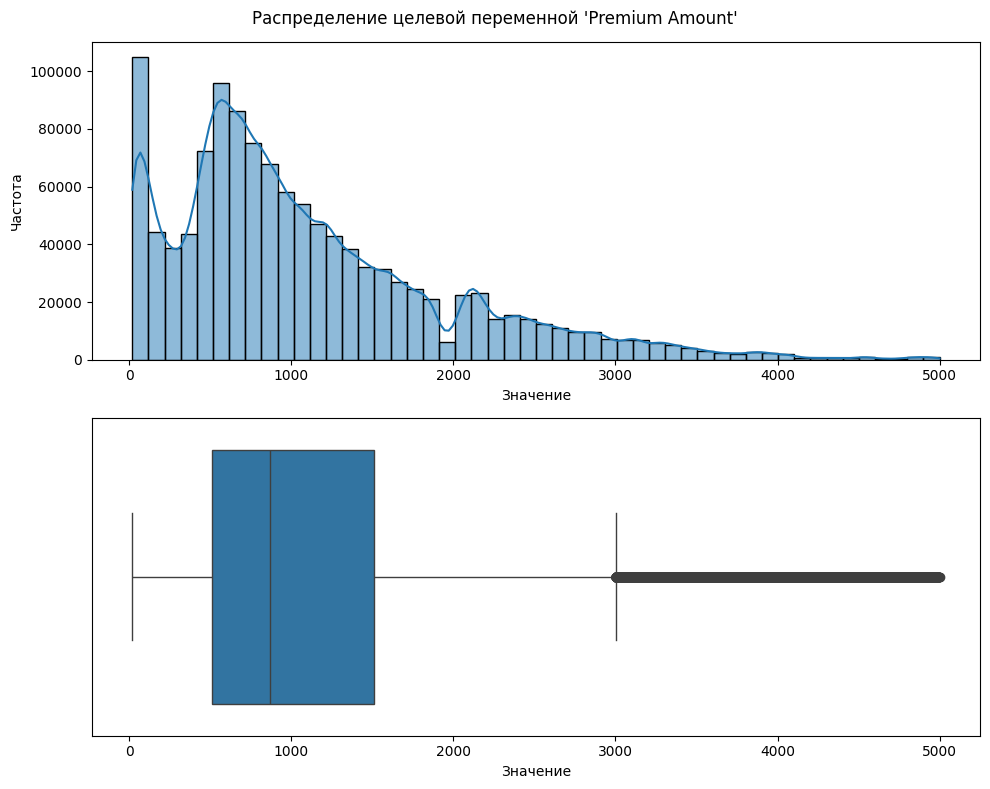

In [11]:
# Визуализация распределения целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df[TARGET], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df[TARGET], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle(f"Распределение целевой переменной '{TARGET}'")
plt.tight_layout()
plt.show()

Распределение целевого признака похоже на распределение Пуассона с тяжелым хвостом, оставим его без изменения.

### Обработка пропусков

Заменим пропуски числовых переменных на значение медианы, а категориальных на значение моды.

In [12]:
# Заполняем числовые переменные
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Заполняем категориальные переменные
# Для случая если встретятся 2 значения с одинаковой частотой, берем первое из них x.mode()[0]
df[categoric_columns] = df[categoric_columns].apply(lambda x: x.fillna(x.mode()[0]))

### Обработка выбросов

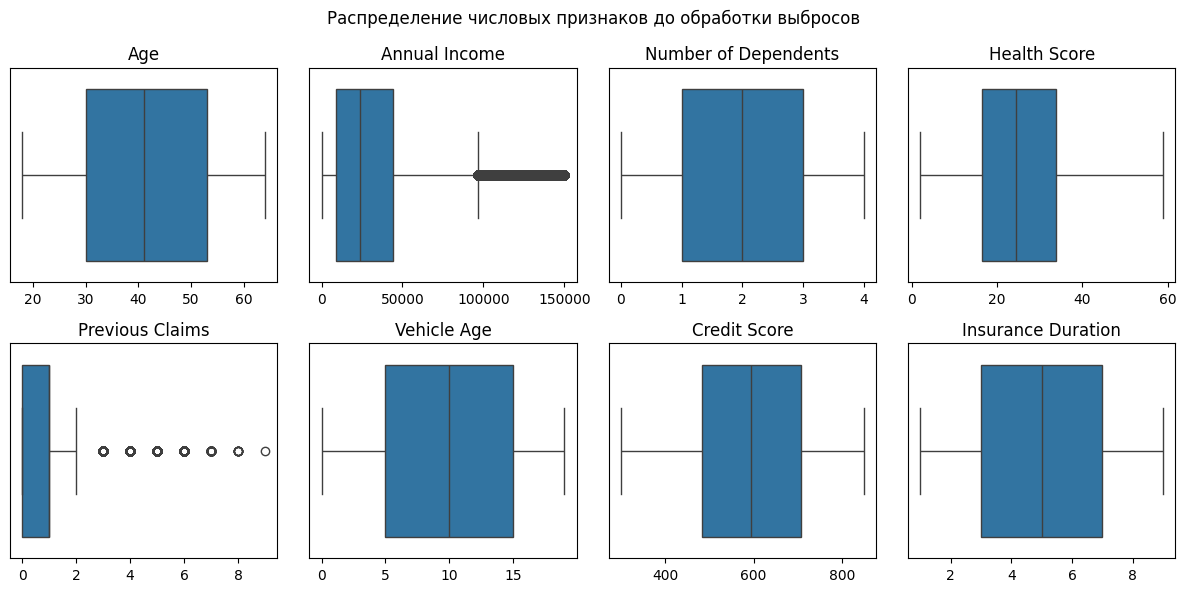

In [13]:
# Отображение распределения числовых признаков до обработки выбросов
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[numeric_columns][col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

plt.suptitle("Распределение числовых признаков до обработки выбросов")
plt.tight_layout()
plt.show()

Больше всего выбросов содержит признак "Annual Income", в нем встречаются как экстримально малые значения (около 1.0) так и очень высокие, выше 100000.0. Заменим низкие значения на величину квантиля 0.1, а высокие на значение межквартильного интервала. Признак "Previus Claims" оставим без изменений, т.к. он дает информацию об особенностях поведения клиентов.

In [14]:
# Функция для обработки выбросов
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = df[col].quantile(0.1)
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df


df = remove_outliers(df, ["Annual Income"])

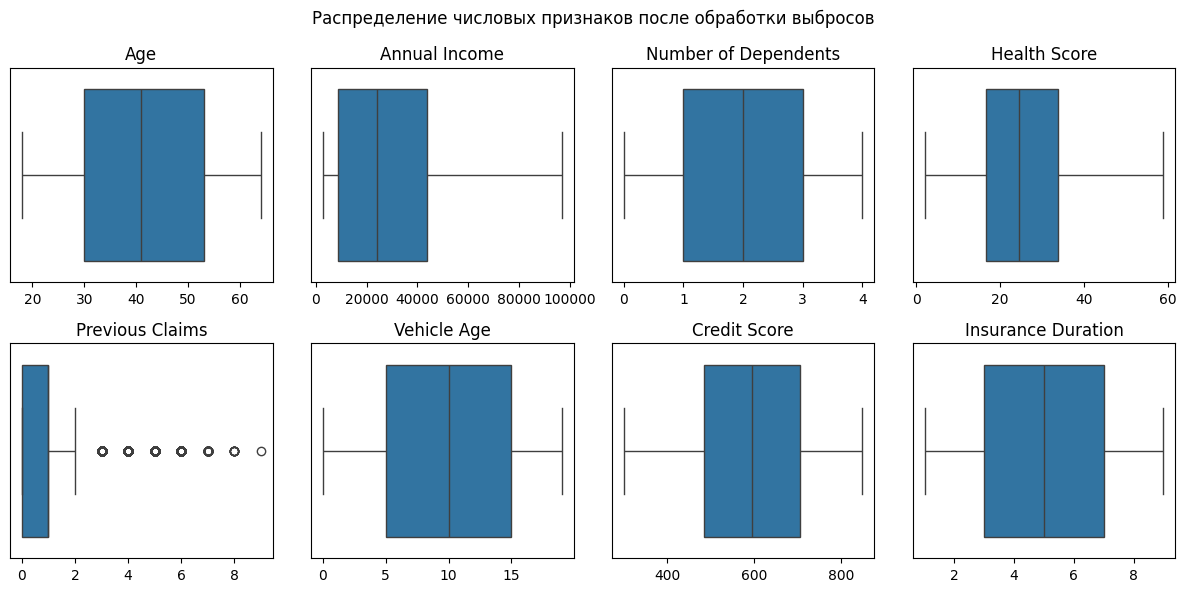

In [15]:
# Отображение распределения числовых признаков после обработки выбросов
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[numeric_columns][col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

plt.suptitle("Распределение числовых признаков после обработки выбросов")
plt.tight_layout()
plt.show()

Выбросы удалены.

EDA после обработки признаков.

In [16]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns + [TARGET]])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
Age,0.0,18.00,64.00,41.14,41.00,1.804700e+02,22.00,60.00,30.00,53.00
Annual Income,0.0,2699.00,96871.00,31122.85,23911.00,7.576037e+08,2699.00,79448.20,8646.00,43936.00
Number of Dependents,0.0,0.00,4.00,2.01,2.00,1.830000e+00,0.00,4.00,1.00,3.00
Health Score,0.0,2.01,58.98,25.55,24.58,1.397900e+02,10.19,42.85,16.55,33.77
Previous Claims,0.0,0.00,9.00,1.00,1.00,6.700000e-01,0.00,2.00,0.00,1.00
Vehicle Age,0.0,0.00,19.00,9.57,10.00,3.336000e+01,2.00,18.00,5.00,15.00
Credit Score,0.0,300.00,849.00,593.16,595.00,1.991035e+04,393.00,787.00,484.00,706.00
Insurance Duration,0.0,1.00,9.00,5.02,5.00,6.730000e+00,1.00,9.00,3.00,7.00
Premium Amount,0.0,20.00,4999.00,1102.55,872.00,7.482235e+05,150.00,2363.00,514.00,1509.00


In [17]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.0,2,Male
Marital Status,0.0,3,Single
Education Level,0.0,4,Master's
Occupation,0.0,3,Employed
Location,0.0,3,Suburban
Policy Type,0.0,3,Premium
Customer Feedback,0.0,3,Average
Smoking Status,0.0,2,Yes
Exercise Frequency,0.0,4,Weekly
Property Type,0.0,3,House


### Кодирование категориальных переменных

In [18]:
# Кодируем методом OneHotEncoding
df = pd.get_dummies(df, columns=categoric_columns, drop_first=True, dtype=int)

df.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.0,5.0,2869.0,0,...,0,1,0,1,0,0,0,1,0,1
1,39.0,31678.0,3.0,15.569731,1.0,12.0,694.0,2.0,1483.0,0,...,1,0,0,0,1,1,0,0,0,1
2,23.0,25602.0,3.0,47.177549,1.0,14.0,595.0,3.0,567.0,1,...,0,1,1,0,1,0,0,1,0,1
3,21.0,96871.0,2.0,10.938144,1.0,0.0,367.0,1.0,765.0,1,...,0,0,0,1,1,0,0,0,0,0
4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.0,4.0,2022.0,1,...,0,1,0,1,1,0,0,1,0,1


### Анализ корреляций

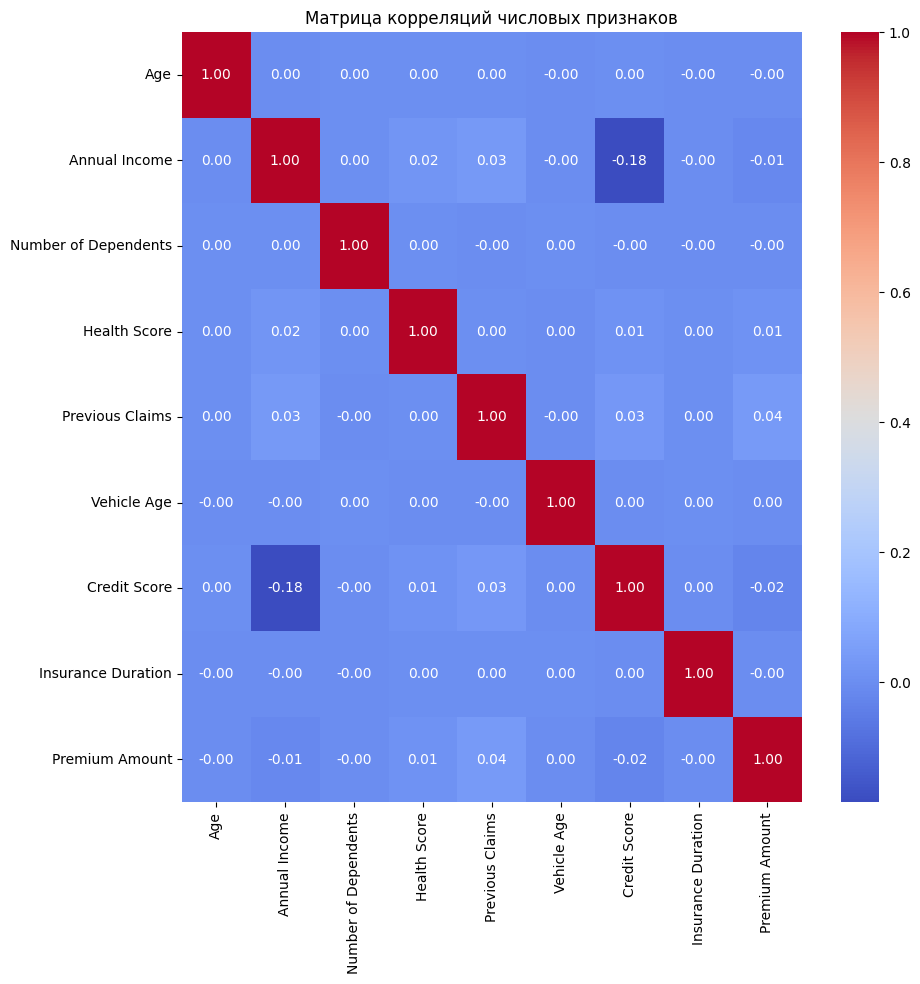

In [19]:
# Матрица корреляций
plt.figure(figsize=(10, 10))
correlation_matrix = df[numeric_columns + [TARGET]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

Заметные корреляции отсутствуют.

### Разделение данных

In [20]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Нормализация числовых данных
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")
X_train.head()

X_train.shape=(959999, 28), y_train.shape=(959999,)
X_test.shape=(240000, 28), y_test.shape=(240000,)


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Married,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
419856,-0.829763,0.167553,0.734208,-0.223246,-0.002622,0.247538,-0.944344,1.534260,0,0,...,1,0,0,0,1,0,0,1,0,1
868117,1.328484,-0.259348,-1.486692,0.784210,-1.221582,0.074435,-0.816762,-0.778105,0,0,...,0,1,0,0,0,0,0,0,0,0
202305,-0.234385,-0.590724,-1.486692,0.099305,-0.002622,-0.791084,1.600203,-1.163499,1,1,...,0,1,0,0,0,1,0,0,0,1
1101536,-0.085540,-1.027908,-0.006092,-0.436219,1.216338,1.113057,0.175540,0.763471,0,0,...,1,0,0,1,0,1,0,0,0,1
717555,-0.532074,-0.991937,1.474508,0.638951,-1.221582,1.286160,0.012519,1.148865,1,0,...,1,0,0,1,0,0,0,1,1,0


## Обучение моделей

In [21]:
linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred_linear = linear.predict(X_test)

Уменьшим количество обучающих данных для модели SVR, поскольку обучение проходит очень медленно.

In [22]:
X_train_sample = X_train.sample(frac=0.1, random_state=RANDOM_STATE, replace=False)
y_train_sample = y_train.sample(frac=0.1, random_state=RANDOM_STATE, replace=False)

print(f"X_train_sample.shape={X_train_sample.shape}, y_train_sample.shape={y_train_sample.shape}")

X_train_sample.shape=(96000, 28), y_train_sample.shape=(96000,)


In [23]:
svr = SVR()
svr.fit(X_train_sample, y_train_sample)

y_pred_svr = svr.predict(X_test)

In [24]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)

y_pred_knr = knr.predict(X_test)

## Оценка качества моделей

In [25]:
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    return {"mae": mae, "mse": mse, "rmse": rmse}


# Сравнительная таблица качества моделей
quality_comparison = pd.DataFrame(
    {
        "Metrics": [*get_metrics(y_test, y_pred_linear).keys()],
        "LinearRegression": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_linear).values(),
            )
        ],
        "SVR": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_svr).values(),
            )
        ],
        "KNeighborsRegressor": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_knr).values(),
            )
        ],
    }
)

quality_comparison

,Metrics,LinearRegression,SVR,KNeighborsRegressor
0,mae,667.81,638.05,718.22
1,mse,748116.66,805862.08,884268.14
2,rmse,864.94,897.70,940.36


Можно видеть, что модель SVR обладает наименьшей метрикой MAE, при этом ее метрика RMSE уступает линейной регрессии. Это означает, что модель в целом хорошо предсказывает результаты, но есть несколько случаев, где модель совершает значительные ошибки, которые сильно увеличивают RMSE. Подберем ее гиперпараметры.

## Подбор гиперпараметров

In [26]:
SEARCH_PARAMS = False

if SEARCH_PARAMS:
    model = SVR()
    param_dist = {
        "C": np.logspace(-3, 3, 10),
        "epsilon": np.linspace(0.01, 1, 10),
        "gamma": ["scale", "auto"] + list(np.logspace(-3, 2, 10)),
        "kernel": ["linear", "poly", "sigmoid", "rbf"],
        "degree": np.arange(2, 4),
        "coef0": np.linspace(0, 1, 5),
    }

    random_search = RandomizedSearchCV(
        model,
        param_dist,
        n_iter=20,
        cv=5,
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=3,
    )
    random_search.fit(X_train_sample, y_train_sample)

    print("Лучшие параметры SVR:", random_search.best_params_)

Лучшие параметры SVR: {'kernel': 'poly', 'gamma': np.float64(0.003593813663804626), 'epsilon': np.float64(0.67), 'degree': np.int64(3), 'coef0': np.float64(0.25), 'C': np.float64(0.004641588833612777)}

Этот набор параметров регуляризует модель, уменьшая риск переобучения (C и gamma низкие). Полиномиальное ядро третьей степени (degree=3) используется для нелинейного разделения данных. epsilon=0.67 говорит о том, что модель не пытается подгонять мелкие отклонения. Такая модель должна быть устойчива к шуму, но возможно недостаточно гибка для сложных зависимостей.

Оценка качества после подбора гиперпараметров.

In [27]:
best_params = {
    "kernel": "poly",
    "gamma": np.float64(0.003593813663804626),
    "epsilon": np.float64(0.67),
    "degree": np.int64(3),
    "coef0": np.float64(0.25),
    "C": np.float64(0.004641588833612777),
}
svr_fine_tune = SVR(**best_params)
svr_fine_tune.fit(X_train_sample, y_train_sample)

y_pred_svr_fine_tune = svr_fine_tune.predict(X_test)

In [28]:
quality_comparison["SVR fine_tune"] = [
    *map(
        lambda x: round(x, 2),
        get_metrics(y_test, y_pred_svr_fine_tune).values(),
    )
]

quality_comparison

,Metrics,LinearRegression,SVR,KNeighborsRegressor,SVR fine_tune
0,mae,667.81,638.05,718.22,642.25
1,mse,748116.66,805862.08,884268.14,804186.78
2,rmse,864.94,897.70,940.36,896.76


Можно видеть, что подбор гиперпараметров с помощью RandomizedSearchCV не привел к улучшению метрик модели.